# Nuclie Semantic Segmentation - UNet using Tensorflow 2

# Intro
- Dataset used is from Kaggle's Data Science Bowl 2018 - Nuclei Segmentation
- The architecture used is [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this.
- This notebook is inspired from the great kernel [Keras U-net starter - LB 0.277](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277) by Kjetil Åmdal-Sævik.

In [3]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import ImageFile

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../data-science-bowl-2018/stage1_train/'
TEST_PATH = '../data-science-bowl-2018/stage1_test/'
FINAL_TEST_PATH = '../data-science-bowl-2018/stage2_test_final/'

#TRAIN_PATH = 'data/stage1_train/'
#TEST_PATH = 'data/stage1_test/'
#FINAL_TEST_PATH = 'data/stage2_test_final/'

dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
print(tf.__version__)

2.3.1


In [4]:
os.getcwd()

'/Users/fight/Documents/Malaria/malatec/Notebooks'

In [5]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
final_test_ids = next(os.walk(FINAL_TEST_PATH))[1]

# Get the data
- Downsample both the training and test images to reduce computations
- Retain record of the original sizes of the test images to upsample predicted masks and create correct run-length encodings 

In [6]:
# Get and resize train images and masks
img_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
mask_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

Getting and resizing train images and masks ... 


In [1]:

sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    #Read image files iteratively
    path = TRAIN_PATH + id_
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for train dataset
    img_train[n] = img
    
    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        
        #Overlay individual masks to create a final mask for corresponding image
        mask = np.maximum(mask, mask_)
    
    #Append mask to numpy array for train dataset
    mask_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    
    #Read images iteratively
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    
    #Get test size
    sizes_test.append([img.shape[0], img.shape[1]])
    
    #Resize image to match training data
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for test dataset
    X_test[n] = img

print('Done!')



NameError: name 'tqdm' is not defined

## Visualize imported data

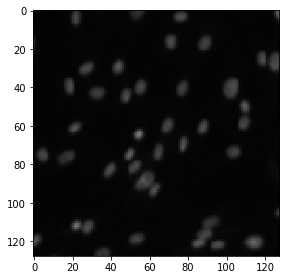

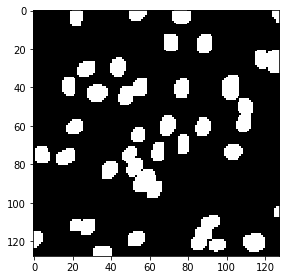

In [8]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(img_train[ix])
plt.show()
imshow(np.squeeze(mask_train[ix]))
plt.show()

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [ ]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)


In [ ]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', verbose=1, save_best_only=True)
results = model.fit(img_train, mask_train, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])


# Make predictions

In [ ]:
# Predict on train, val and test
model = load_model('model_unet_checkpoint.h5')
preds_train = model.predict(img_train[:int(img_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(img_train[int(img_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test_t)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test_t[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))
imshow(img_train[ix])
plt.show()
imshow(np.squeeze(mask_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(img_train[int(img_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(mask_train[int(mask_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# Encode and submit our results

- [Link](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) has an excellent implementation of run-length encoding.

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

- Iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

- Create submission

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)